In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

import cv2
import sys
import os
import torch
from tqdm import tnrange

sys.path.insert(0, '..')
from adaptis.inference.adaptis_sampling import get_panoptic_segmentation
from adaptis.inference.prediction_model import AdaptISPrediction

device = torch.device('cuda')

### Init dataset

In [2]:
from adaptis.data.cityscapes import CityscapesDataset

dataset_path = '/share/data/vision-greg/cityscapes'
dataset = CityscapesDataset(dataset_path, split='val', with_segmentation=True)

### Load model

In [4]:
from adaptis.model.cityscapes.models import get_cityscapes_model

model = get_cityscapes_model(num_classes=19, norm_layer=torch.nn.BatchNorm2d, backbone='resnet50', with_proposals=True)
pmodel = AdaptISPrediction(model, dataset, device)

weights_path = '../experiments/cityscapes/003/checkpoints/proposals_last_checkpoint.pth'
pmodel.net.load_state_dict(torch.load(weights_path)['model_state'])

<All keys matched successfully>

### Test on one image

In [8]:
proposals_sampling_params = {
    'thresh1': 0.4,
    'thresh2': 0.5,
    'ithresh': 0.3,
    'fl_prob': 0.10,
    'fl_eps': 0.003,
    'fl_blur': 2,
    'max_iters': 100
}

image_path = os.path.join(dataset_path, 'leftImg8bit/test/berlin', 'berlin_000494_000019_leftImg8bit.png')
print(image_path)

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pred = get_panoptic_segmentation(pmodel, image,
                                 sampling_algorithm='proposals',
                                 use_flip=True, **proposals_sampling_params)

/share/data/vision-greg/cityscapes/leftImg8bit/test/berlin/berlin_000494_000019_leftImg8bit.png


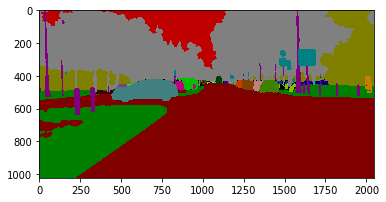

In [9]:
import pylab
pylab.imshow(dataset.convert_to_coco_format(pred)['annotation'])

In [10]:
def show(ix):
    import pylab
    pylab.figure(figsize=(20,10))
    pylab.imshow((pred['instances_mask'] == ix).astype('float32')[...,None] * 0.5  + image.astype('float32')/255/2)
import ipywidgets as widgets
widgets.interact(show, ix=widgets.BoundedIntText(min=0, max=len(pred['masks']), value=0))

interactive(children=(BoundedIntText(value=0, description='ix', max=22), Output()), _dom_classes=('widget-inte…

<function __main__.show(ix)>

### Define evaluation function

In [13]:
from adaptis.coco.panoptic_metric import PQStat, pq_compute, print_pq_stat

def test_model(pmodel, dataset,
               sampling_algorithm, sampling_params,
               use_flip=False, cut_radius=-1):
    pq_stat = PQStat()
    categories = dataset._generate_coco_categories()
    categories = {x['id']: x for x in categories}

    for indx in tnrange(len(dataset)):
        sample = dataset.get_sample(indx)
        pred = get_panoptic_segmentation(pmodel, sample['image'],
                                         sampling_algorithm=sampling_algorithm,
                                         use_flip=use_flip, cut_radius=cut_radius, **sampling_params)
        
        
        coco_sample = dataset.convert_to_coco_format(sample)
        pred = dataset.convert_to_coco_format(pred)

        pq_stat = pq_compute(pq_stat, pred, coco_sample, categories)
    
    print_pq_stat(pq_stat, categories)

### Test proposals-based point sampling

In [14]:
test_model(pmodel, dataset,
           sampling_algorithm='proposals',
           sampling_params=proposals_sampling_params,
           use_flip=True)


          |     PQ      SQ      RQ     N
--------------------------------------
All       |  53.14   79.07   65.69    19
Things    |  40.37   77.57   51.92     8
Stuff     |  62.43   80.16   75.70    11
